# Spark DataFrame Example: Word Count on Shakespeare

This notebook demonstrates how to use Spark DataFrames to process text data through a complete data transformation pipeline.

## Learning Objectives

By working through this example, you will:
- Understand how DataFrames provide a structured approach to data processing
- Learn the declarative "what not how" programming paradigm
- See how the Catalyst optimizer enhances performance
- Understand Spark execution plans and two-phase aggregation
- Practice transforming unstructured data into structured insights

## What We'll Build

We'll create a complete data processing pipeline:

1. **Load**: Read unstructured text (Shakespeare's complete works)
2. **Transform**: Convert raw text into structured DataFrame
3. **Clean**: Normalize words (lowercase, remove punctuation)
4. **Aggregate**: Count word frequencies
5. **Analyze**: Sort and visualize results

This pattern applies to any data processing task at scale.

## Key Concepts

**Declarative Programming**: With DataFrames, you specify *what* you want, not *how* to compute it. Spark's Catalyst optimizer figures out the most efficient execution strategy.

**Lazy Evaluation**: Transformations are not executed immediately. Spark builds an execution plan and only runs it when you call an action (like `.collect()` or `.show()`).

**Catalyst Optimizer**: Spark's query optimizer that applies intelligent transformations like predicate pushdown, column pruning, and two-phase aggregation to make your code run faster.

In [1]:
# Imports
import time
import urllib.request
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    explode, split, lower, col, regexp_replace, length
)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Download Shakespeare text
FILEPATH = "shakespeare.txt"
URL = "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"

if not Path(FILEPATH).exists():
    print(f"Downloading from {URL}...")
    urllib.request.urlretrieve(URL, FILEPATH)
    print("Download complete!")

file_size = Path(FILEPATH).stat().st_size
print(f"File size: {file_size / 1024:.1f} KB ({file_size / 1024 / 1024:.2f} MB)")

Download complete!
File size: 5330.3 KB (5.21 MB)


In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Spark_DataFrame_Word_Count_Example") \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")

print(f"Spark version: {spark.version}")
print(f"Running on: {sc.master}")

2026-01-28 16:10:02 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.5.0
Running on: local[*]


### Important: Spark Session Initialization

**Note for Databricks users**: In Databricks notebooks, the Spark session is automatically created and available as the `spark` variable. You don't need to create it explicitly.

**This example runs in a codespace environment** where explicit session creation is required using `SparkSession.builder`. When moving between local development and cloud platforms like Databricks, remember this key difference:

- **Local/Codespace**: Must create session with `SparkSession.builder.getOrCreate()`
- **Databricks**: Session pre-created, just use the `spark` variable

This is one of the conveniences of managed Spark environments like Databricks!

## Data Overview

We're working with the **Complete Works of William Shakespeare** from MIT OpenCourseWare. This dataset includes:

- All of Shakespeare's plays (tragedies, comedies, histories)
- All sonnets and poems
- Approximately 5.3 MB of text
- Over 900,000 words total

This is a great dataset for word frequency analysis because:
- Large enough to see Spark's distributed processing
- Real-world literary text with rich vocabulary
- Publicly available and well-known

---
## The Declarative Approach

With DataFrames, you write code that describes **what** you want to achieve, not **how** to implement it step-by-step.

Think of it like SQL: you specify the transformations you want, and Spark's Catalyst optimizer figures out the most efficient way to execute them.

**Benefits**:
- More readable and maintainable code
- Automatic performance optimizations
- Language-independent (same code pattern in Python, Scala, Java)
- Catalyst can reorder operations, push down filters, and use two-phase aggregations

In [4]:
def word_count_dataframe(filepath: str):
    """
    DataFrame word count - declarative style.
    
    We specify WHAT we want:
    - Split lines into words
    - Normalize to lowercase and remove punctuation
    - Count occurrences
    - Sort by frequency
    
    Catalyst optimizer figures out HOW to execute efficiently.
    """
    return (
        spark.read.text(filepath)
        # Split into words and explode to rows
        .select(explode(split(col("value"), r"\s+")).alias("word"))
        # Normalize: lowercase, keep only letters
        .select(regexp_replace(lower(col("word")), r"[^a-z]", "").alias("word"))
        # Filter empty strings
        .filter(length(col("word")) > 0)
        # Group and count
        .groupBy("word").count()
        # Sort by frequency descending
        .orderBy(col("count").desc())
    )

### Step-by-Step Transformation Breakdown

Let's understand each transformation in our pipeline:

1. **`spark.read.text(filepath)`**: Loads the text file as a DataFrame with one column called `value`. Each line becomes one row.

2. **`explode(split(col("value"), r"\s+"))`**: Splits each line on whitespace into an array, then explodes the array so each word becomes its own row. One line with 10 words → 10 rows.

3. **`regexp_replace(lower(col("word")), r"[^a-z]", "")`**: Converts to lowercase and removes all non-letter characters (punctuation, numbers). "Hello!" → "hello"

4. **`filter(length(col("word")) > 0)`**: Removes empty strings that resulted from pure punctuation.

5. **`groupBy("word").count()`**: Groups identical words together and counts occurrences. This triggers a **shuffle** - data is redistributed across partitions.

6. **`orderBy(col("count").desc())`**: Sorts by count in descending order to show most frequent words first.

In [5]:
# Execute and display results
start = time.perf_counter()
df_result = word_count_dataframe(FILEPATH).collect()
execution_time = time.perf_counter() - start

print(f"Execution time: {execution_time:.3f}s\n")
print("Top 20 words in Shakespeare:")
print("=" * 40)
for i, row in enumerate(df_result[:20], 1):
    print(f"{i:2d}. {row['word']:15} {row['count']:>6,}")

Execution time: 5.851s

Top 20 words in Shakespeare:
 1. the             27,643
 2. and             26,728
 3. i               20,681
 4. to              19,198
 5. of              18,173
 6. a               14,613
 7. you             13,649
 8. my              12,480
 9. that            11,121
10. in              10,967
11. is               9,598
12. not              8,725
13. for              8,244
14. with             7,996
15. me               7,768
16. it               7,690
17. be               7,090
18. your             6,882
19. his              6,857
20. this             6,847


### Key Observations

**Declarative code**: The function reads like a description of the transformation, not implementation details. You can understand what it does without knowing how Spark executes it.

**Schema awareness**: Each transformation understands column types. The `count()` aggregation knows it's working with strings grouped by key.

**Lazy evaluation**: The transformation chain isn't executed until `.collect()` is called. Spark uses this time to analyze and optimize the entire plan.

**Performance**: Despite running locally, this processes ~900,000 words efficiently. The same code scales to terabytes of data on a cluster.

**Common words dominate**: English follows Zipf's law - a few function words ("the", "and", "of") account for a large percentage of all text.

---
## Understanding Spark Execution Plans

One of Spark's most powerful features is **query optimization**. When you write DataFrame code, Spark doesn't execute it directly. Instead:

1. **Logical Plan**: Spark converts your code into a logical plan of operations
2. **Optimized Plan**: The Catalyst optimizer applies transformations (predicate pushdown, constant folding, etc.)
3. **Physical Plan**: Spark generates the actual execution strategy

The **physical execution plan** shows exactly how Spark will execute your query. Let's examine it!

**How to read execution plans**: Read **bottom-up**. Data flows from step (1) at the bottom upward to the final result.

In [6]:
# Display execution plan
df_query = word_count_dataframe(FILEPATH)

print("=" * 70)
print("PHYSICAL EXECUTION PLAN")
print("=" * 70)
df_query.explain(mode="formatted")

PHYSICAL EXECUTION PLAN
== Physical Plan ==
AdaptiveSparkPlan (10)
+- Sort (9)
   +- Exchange (8)
      +- HashAggregate (7)
         +- Exchange (6)
            +- HashAggregate (5)
               +- Project (4)
                  +- Filter (3)
                     +- Generate (2)
                        +- Scan text  (1)


(1) Scan text 
Output [1]: [value#16]
Batched: false
Location: InMemoryFileIndex [file:/workspaces/dscc202-402-spring2026/reference_material/slides/shakespeare.txt]
ReadSchema: struct<value:string>

(2) Generate
Input [1]: [value#16]
Arguments: explode(split(value#16, \s+, -1)), false, [word#19]

(3) Filter
Input [1]: [word#19]
Condition : (length(regexp_replace(lower(word#19), [^a-z], , 1)) > 0)

(4) Project
Output [1]: [regexp_replace(lower(word#19), [^a-z], , 1) AS word#22]
Input [1]: [word#19]

(5) HashAggregate
Input [1]: [word#22]
Keys [1]: [word#22]
Functions [1]: [partial_count(1)]
Aggregate Attributes [1]: [count#29L]
Results [2]: [word#22, count#30L]

(6) 

### Execution Plan Walkthrough

Let's break down what each step means (reading bottom-up):

#### **Step 1: Scan text**
Reads the raw text file. Each line becomes one row with a single column called `value`. The `ReadSchema` confirms Spark only reads what we need (column pruning optimization).

#### **Step 2: Generate** 
The `explode(split(...))` operation. Splits each line on whitespace and "explodes" the resulting array so each word becomes its own row. One line with 10 words → 10 rows.

#### **Step 3: Filter**
Removes empty strings. Notice the condition combines `lower()`, `regexp_replace()`, and `length()` - **Catalyst fused these operations** into a single pass rather than doing three separate iterations. This is predicate fusion!

#### **Step 4: Project**
Applies the lowercase + regex cleanup transformation to produce normalized words.

#### **Step 5: HashAggregate (partial)**
This is the first half of **two-phase aggregation**. Each partition computes local counts *before* shuffling. Instead of shuffling every word occurrence, Spark shuffles pre-aggregated `(word, partial_count)` pairs. Major optimization!

#### **Step 6: Exchange** ⚠️ **SHUFFLE**
Data is redistributed across the cluster using `hashpartitioning(word, 8)`. All occurrences of the same word end up on the same partition. Shuffles involve network I/O and are expensive, which is why Spark minimizes them.

#### **Step 7: HashAggregate (final)**
Combines the partial counts from all partitions into final counts per word.

#### **Step 8: Exchange (for sorting)**
Another shuffle using `rangepartitioning` to prepare for global sorting. Data is distributed so partition 1 has the highest counts, partition 2 the next highest, etc.

#### **Step 9: Sort**
Sorts within each partition. Because of range partitioning, the final result is globally sorted.

#### **Step 10: AdaptiveSparkPlan**
Wrapper indicating **Adaptive Query Execution (AQE)** is enabled. Spark can modify this plan at runtime based on actual data statistics.

### Key Concepts from the Execution Plan

| Concept | What It Means | Why It Matters |
|---------|---------------|----------------|
| **Two-Phase Aggregation** | Partial aggregation → shuffle → final aggregation | Reduces data movement by pre-aggregating locally |
| **Exchange (Shuffle)** | Data redistribution across partitions | Expensive operation; necessary for correct grouping |
| **HashPartitioning** | `hash(key) % num_partitions` determines partition | Ensures all same keys go to same partition |
| **Predicate Pushdown** | Filters applied early in the pipeline | Reduces data processed in later stages |
| **AdaptiveSparkPlan** | Runtime optimization enabled | Spark adjusts plan based on actual data characteristics |

**The Big Picture**: Catalyst automatically applied optimizations we didn't ask for! The two-phase aggregation and predicate fusion make the code significantly faster than a naive implementation.

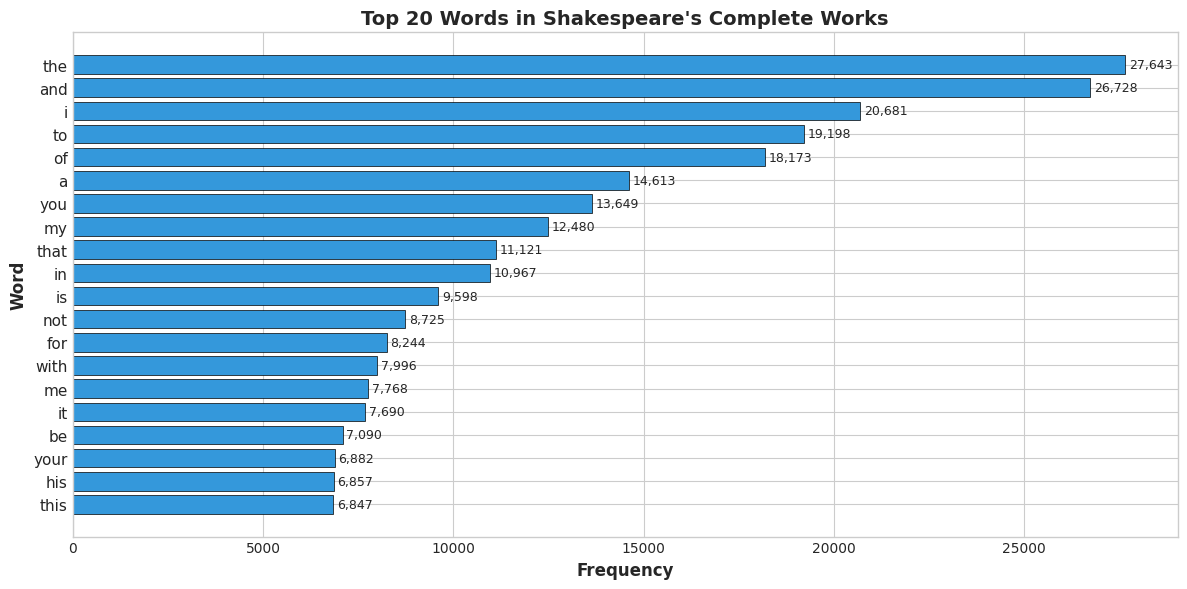


Visualization saved to: shakespeare_top_words.png


In [7]:
# Visualize top 20 words
top_words = df_result[:20]
words = [row["word"] for row in top_words]
counts = [row["count"] for row in top_words]

plt.figure(figsize=(12, 6))
y_pos = np.arange(len(words))
plt.barh(y_pos, counts, color='#3498db', edgecolor='black', linewidth=0.5)
plt.yticks(y_pos, words, fontsize=11)
plt.gca().invert_yaxis()
plt.xlabel("Frequency", fontsize=12, fontweight='bold')
plt.ylabel("Word", fontsize=12, fontweight='bold')
plt.title("Top 20 Words in Shakespeare's Complete Works", fontsize=14, fontweight='bold')

# Add count labels
for i, count in enumerate(counts):
    plt.text(count + 100, i, f"{count:,}", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('shakespeare_top_words.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: shakespeare_top_words.png")

---
## Key Takeaways

### 1. Declarative Approach
Write **what** you want, let Spark handle **how**. This makes code more readable and maintainable.

### 2. Efficient Execution
Catalyst optimizer applies intelligent transformations like two-phase aggregation and predicate pushdown automatically.

### 3. Lazy Evaluation
Transformations don't execute until an action is called. This allows Spark to optimize the entire pipeline before running anything.

### 4. Scalability
The same code works on gigabytes or terabytes of data. Spark handles partitioning and distribution automatically.

### 5. Readable & Expressive
DataFrame API with SQL-like syntax is intuitive for data analysts and engineers. The execution plan provides visibility into how Spark runs your code.

---

**Next Steps**: Explore more complex transformations like joins, window functions, and custom aggregations. The declarative pattern scales to much more sophisticated analytics!

In [ ]:
# Cleanup
spark.stop()
print("Spark session stopped.")
print("\nGreat job! You've completed a full Spark DataFrame transformation pipeline.")